In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras import Input
import utils
import metrics

# MNIST dataset params
num_classes = 10 # 0-9 digits
num_features = 784 # img shape: 28*28

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# pre-process data
X_train, y_train, X_test, y_test = utils.preprocess(X_train, y_train, X_test, y_test, num_classes, num_features, print_summary=False)

from tensorflow.keras.utils import to_categorical

# Convert target classes to categorical ones (one-hot encoding) - only for training and tuning
y_train_enc = to_categorical(y_train, num_classes)
y_test_enc = to_categorical(y_test, num_classes)

In [7]:
# network loss function
loss =tf.keras.losses.CategoricalCrossentropy()

# network metrics
eval_metrics = [metrics.f1]

# training batch size
batch_size = 256

# training epochs
epochs = 1000

# print options during training
verbose = 1

# early stopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=200)

# **$1$. Fine Tuning**

In [8]:
import keras_tuner

def build_model(hp):

    # hyperparams
    n_hidden_1      =   hp.Choice("units_1", [64, 128])
    n_hidden_2      =   hp.Choice("units_2", [256, 512])
    a_reg           =   hp.Choice("a_reg", [0.1, 0.001, 0.000001])
    learning_rate   =   hp.Choice("learning_rate", [0.1, 0.01, 0.001])

    # mlp model
    mlp_rmsprop_ft = keras.Sequential(name="MLP_RMSProp_FT")

    mlp_rmsprop_ft.add(Input(shape=(num_features,)))

    mlp_rmsprop_ft.add(keras.layers.Dense(name="hidden_layer_1", units=n_hidden_1, activation="relu", 
                        kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))

    mlp_rmsprop_ft.add(keras.layers.Dense(name="hidden_layer_2", units=n_hidden_2, activation="relu", 
                        kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))

    mlp_rmsprop_ft.add(keras.layers.Dense(name="output_layer", units=num_classes, activation="softmax", 
                        kernel_regularizer=regularizers.l2(a_reg), kernel_initializer=initializers.HeNormal()))
    
    mlp_rmsprop_ft.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                            loss=loss, 
                            metrics=eval_metrics)

    return mlp_rmsprop_ft

tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=20,
    overwrite=False,
    directory="tuning",
    project_name="mlp_tuning",
)

tuner.search_space_summary()

INFO:tensorflow:Reloading Oracle from existing project tuning\mlp_tuning\oracle.json
INFO:tensorflow:Reloading Tuner from tuning\mlp_tuning\tuner0.json
Search space summary
Default search space size: 4
units_1 (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
units_2 (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512], 'ordered': True}
a_reg (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.001, 1e-06], 'ordered': True}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001], 'ordered': True}


In [7]:
tuner.search(X_train, y_train_enc, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test_enc), verbose=verbose, callbacks=[callback])

INFO:tensorflow:Oracle triggered exit


In [17]:
print("Optimal model:")
best_model = tuner.get_best_models()[0]
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_model.summary()

print("Optimal parameters:")
n_hidden_1_opt   = best_hyperparameters.get("units_1")
n_hidden_2_opt   = best_hyperparameters.get("units_2")
a_reg_opt           = best_hyperparameters.get("a_reg")
learning_rate_opt   = best_hyperparameters.get("learning_rate")

print("n_hidden_1 =", n_hidden_1_opt)
print("n_hidden_2 =", n_hidden_2_opt)
print("a_reg =", a_reg_opt)
print("learning rate =", learning_rate_opt)


Optimal model:
Model: "MLP_RMSProp_FT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 128)               100480    
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               33024     
                                                                 
 output_layer (Dense)        (None, 10)                2570      
                                                                 
Total params: 136,074
Trainable params: 136,074
Non-trainable params: 0
_________________________________________________________________
Optimal parameters:
n_hidden_1 = 128
n_hidden_2 = 256
a_reg = 1e-06
learning rate = 0.001


# **$2$. Optimal Model**

## $a$. Training

In [22]:
# mlp model
mlp_rmsprop_opt = keras.Sequential(name="MLP_RMSProp_Opt")

mlp_rmsprop_opt.add(Input(shape=(num_features,)))

mlp_rmsprop_opt.add(keras.layers.Dense(name="hidden_layer_1", units=n_hidden_1_opt, activation="relu", 
                    kernel_regularizer=regularizers.l2(a_reg_opt), kernel_initializer=initializers.HeNormal()))

mlp_rmsprop_opt.add(keras.layers.Dense(name="hidden_layer_2", units=n_hidden_2_opt, activation="relu", 
                    kernel_regularizer=regularizers.l2(a_reg_opt), kernel_initializer=initializers.HeNormal()))

mlp_rmsprop_opt.add(keras.layers.Dense(name="output_layer", units=num_classes, activation="softmax", 
                    kernel_regularizer=regularizers.l2(a_reg_opt), kernel_initializer=initializers.HeNormal()))

mlp_rmsprop_opt.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate_opt),
                        loss=loss, 
                        metrics=eval_metrics)

history = mlp_rmsprop_opt.fit(X_train, y_train_enc, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test_enc), callbacks=[callback])

Epoch 1/1000
219/219 [==============================] - 2s 6ms/step - loss: 0.3316 - f1: 0.9397 - val_loss: 0.1888 - val_f1: 0.9586
Epoch 2/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.1442 - f1: 0.9651 - val_loss: 0.1215 - val_f1: 0.9706
Epoch 3/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.0986 - f1: 0.9752 - val_loss: 0.1040 - val_f1: 0.9733
Epoch 4/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.0736 - f1: 0.9810 - val_loss: 0.0976 - val_f1: 0.9750
Epoch 5/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.0578 - f1: 0.9846 - val_loss: 0.0893 - val_f1: 0.9759
Epoch 6/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.0458 - f1: 0.9875 - val_loss: 0.0866 - val_f1: 0.9772
Epoch 7/1000
219/219 [==============================] - 1s 5ms/step - loss: 0.0372 - f1: 0.9901 - val_loss: 0.0876 - val_f1: 0.9784
Epoch 8/1000
219/219 [==============================] - 1s 5ms/step - loss: 

## $b$. Results - Evaluation

### $i)$ Confusion Matrix

In [23]:
# predict classes
y_pred = utils.predict_classes(mlp_rmsprop_opt, X_test)

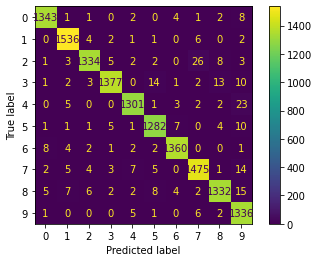

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

confusion_matrix_ = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix_).plot()

TN = 125676 
FP = 324 
FN = 324 
TP = 13676 
SUM = 140000
Accuracy = 0.9953714285714286 
Recall = 0.9768571428571429 
Precision = 0.9768571428571429 
F1 = 0.9768571428571429


<Figure size 10800x3600 with 0 Axes>

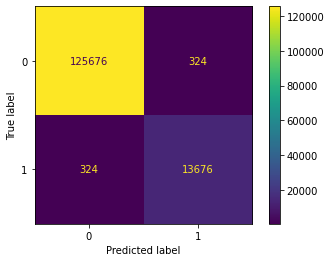

In [41]:
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np

multilabel_confusion_matrix_ = multilabel_confusion_matrix(y_test, y_pred)
confusion_matrix_ = np.sum(multilabel_confusion_matrix_, axis = 0)
ConfusionMatrixDisplay(confusion_matrix_).plot()

tn = confusion_matrix_[0][0]
fp = confusion_matrix_[0][1]
fn = confusion_matrix_[1][0]
tp = confusion_matrix_[1][1]
sum = tn + fp + fn + tp

print("TN =", tn, "\nFP =", fp, "\nFN =", fn, "\nTP =", tp, "\nSUM =", sum)

accuracy = (tp + tn) / sum
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print("Accuracy =", accuracy, "\nRecall =", recall, "\nPrecision =", precision, "\nF1 =", f1)

### $ii)$ Learning Curves

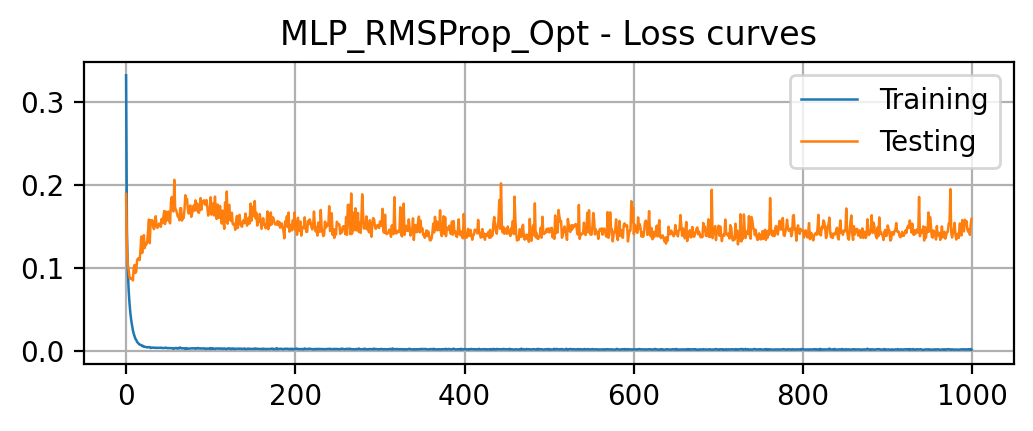

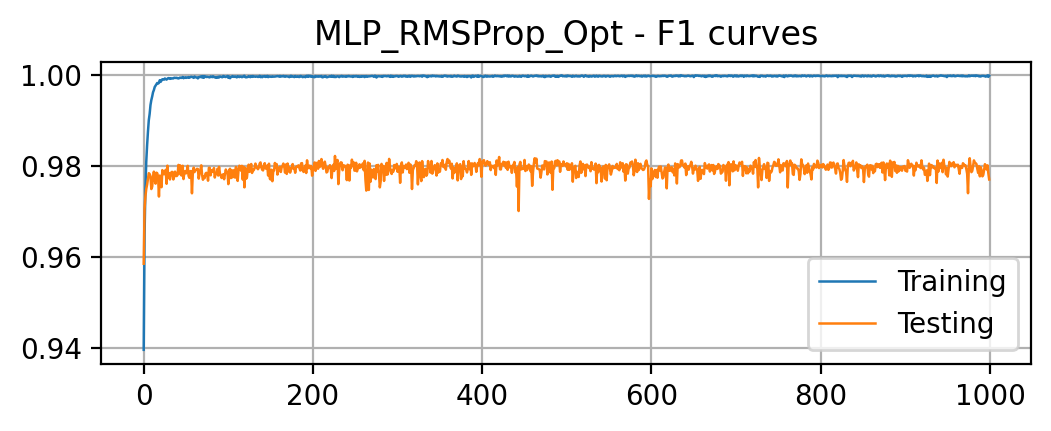

In [87]:
import matplotlib.pyplot as plt

loss_train = history.history["loss"]
loss_test = history.history["val_loss"]

f1_train = history.history["f1"]
f1_test = history.history["val_f1"]

plt.ion()
plt.figure(figsize=(6, 2), dpi=200)
plt.plot(loss_train, label="Training", linewidth=0.9)
plt.plot(loss_test, label="Testing", linewidth=0.9)
plt.title(mlp_rmsprop_opt.name + " - Loss curves")
plt.legend()
plt.grid()
plt.savefig("fig/" + mlp_rmsprop_opt.name + "_Loss.jpg", dpi=1200)
plt.show()

plt.figure(figsize=(6, 2), dpi=200)
plt.plot(f1_train, label="Training", linewidth=0.9)
plt.plot(f1_test, label="Testing", linewidth=0.9)
plt.title(mlp_rmsprop_opt.name + " - F1 curves")
plt.legend()
plt.grid()
plt.savefig("fig/" + mlp_rmsprop_opt.name + "_F1.jpg", dpi=1200)
plt.show()